In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
import os

In [27]:
sys.path.append('Neural_Network_DNA_Demo/')
from helper import IOHelper, SequenceHelper # from https://github.com/bernardo-de-almeida/Neural_Network_DNA_Demo.git

### load fasta sequences functions
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1):
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1


def prepare_input(file_seq):
    # Convert sequences to one-hot encoding matrix
    input_fasta_data_A = IOHelper.get_fastas_from_file(file_seq, uppercase=True)

    # get length of first sequence
    sequence_length = len(input_fasta_data_A.sequence.iloc[0])

    # Convert sequence to one hot encoding matrix
    seq_matrix_A = SequenceHelper.do_one_hot_encoding(input_fasta_data_A.sequence, sequence_length,
      SequenceHelper.parse_alpha_to_seq)
    print(seq_matrix_A.shape)

    X = np.nan_to_num(seq_matrix_A) # Replace NaN with zero and infinity with large finite numbers
    X_reshaped = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

    print(file_seq)

    return X_reshaped

In [28]:
### Load Arguments
#fdiry = "/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data"
#fdiry = "/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_results"
fdiry = "/home/mount/work/out/proj_combeffect/peak"
model_name = "Model_DeepSTARR"
seq_name   = "chr17.fa"

TASK1="DMSO"
TASK2="Dex"

args = {
    #"m": "DeepSTARR.model", 
    #"m": "Model_DeepSTARR_tf114", 
    #"s": "Sequences_example.fa",
    #"c": "dev"
    "m": os.path.join(fdiry, "cradle_deepstarr_results", model_name), 
    "s": os.path.join(fdiry, "cradle_deepstarr_data",    seq_name),
    "c": "Dex"
}
model_ID = args["m"] 
sequence_set = args["s"]
class_output = args["c"]

In [29]:
print("\nLoading sequences and model ...\n")
#X_all = prepare_input(sequence_set)
X_all = IOHelper.get_fastas_from_file(sequence_set, uppercase=True)

print(type(X_all))
print(len(X_all))
X_all.head()


Loading sequences and model ...

<class 'pandas.core.frame.DataFrame'>
3601


,location,sequence
0,chr17:409725-410725,ATCCCAGCGATCTAGGAGGCCGAGGCGGGAAGATCGATGGAGCCCA...
1,chr17:409925-410925,CAACTGTCCAGATTCCAACAGACAAAAGCAAGCATGGGCGAACCAC...
2,chr17:494432-495432,GCGGCTCAGCCCCTGGAAGTCAGGAGTGTTTCCATAGTCCTGAGCA...
3,chr17:497086-498086,ACTCCAAAGGCAGGCTCAAAGGTCTCCATGGTACTCCAGGGCCCCT...
4,chr17:502352-503352,TGGTTTTTTTTTTGTTGTTGTTTTTTGAGACAGTCTCACTCTGGCT...


In [30]:
np.random.seed(123)
idx = np.random.choice(X_all.shape[0], size=100)

fasta_sequences = X_all.sequence.to_numpy()[idx]
print(len(fasta_sequences))
print(fasta_sequences[0])

100
TTGTTAATTGAATAGCCTTCACATTTGTTGCTTGTGCAGGATCTAATTGAGTTAAAGATTTGGGTTTATATTGGTGGGAGCCGGGGGAGACCGTTTGAAGGAAAAGATTTAGGGGTAACAAAAGAATAAAAGTTTCCCAAAATGTGATGTATAAAAATTTACAGAATGCTGGTATTTCCCTCAATAAGAGCTTACACAATTTAACAGCCATGAGAGGAAGGGGCCTTAGACTTAACACAACGTGGAGAATGTTCACTTTGGCTTTTCCACAGATTCCTCTCAAAGGTTACCATCGACTTTAAGATTAGTATTAATAGAAGCTGTTTTTGCTGTTGTTTTTGATTTCATGGTGTTTTTGATTGCCTGGGTACGCTAACTTGATTTTTTGACAGATGGTTGGCAATGGCTGATAAATGACACTTTGAGACATCTCCATCTCATCTCAAGTCACTCCCGCCAGCAGATGAAGGTACAGTGAGCATGGGCGTTCCCGGCCGGCGCTGTGGCGGTGTTAGTGTGTTAGTCACGGATGGTGTTTGTGTTGGCGACTGTGCATCATGAGGCTGTCCCTGCAGTAGCCTGATAACTGACAAATGGGGGCATAATTCTATTTGGAATCCCGGATGGTAGCGTCTACACGGTTTATAACCAGAAAATCCAATACAGCCATTGGAATCCGAATGTTTAATTTTTTATTGCTTCTGGCTGTTTTAATTATAGTTACCTTTGAAATACTTTTTCTGCATCAATAGTAACTGTGCTCTGTTGAGTTCCGTGTCCTGTAGGATCTGAGGTTTGGAAACTCCCTTTATGATGCTCCTGTGCAGATGAGAAAACAGCACCCCAGGACCTCTGCTCGCACACATTGACCTGGTCATGTTGTGTGGGTGCCAGTGTGTGTGTGTGTCCCCGGCCACCTGCCCTCCCCTCCCGTCCTGGGGGTTACAGGTGGACTTTGGACTCACAGAGCTGTAACGCTGATCTCATTGCATAGAT

- contrib_scores
- hyp_contrib_scores

In [33]:
import h5py
from collections import OrderedDict
import numpy as np

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

#f = h5py.File("scores.h5","r")
fdiry = "/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_results"
fname = "chr17_Model_DeepSTARR_Dex_contribution_scores.h5"
fpath = os.path.join(fdiry, fname)
f = h5py.File(fpath, "r")

tasks = f["contrib_scores"].keys()
n = 100
#n = len(fasta_sequences)
#n = 100 #len(fasta_sequences) #100 #since this is just a test run, for speed I am limiting to 100 sequences
#reverse-complement some of the sequences to simulate that
take_rc = (np.random.RandomState(1234).uniform(size=n) > 0.5)
for task in tasks:
    #Note that the sequences can be of variable lengths;
    #in this example they all have the same length (200bp) but that is
    #not necessary.
    task_to_scores[task] = [np.array(x) if not rc else np.array(x)[::-1,::-1]
                            for x,rc in zip(f['contrib_scores'][task][:n], take_rc)]
    task_to_hyp_scores[task] = [np.array(x) if not rc else np.array(x)[::-1,::-1]
                                for x,rc in zip(f['hyp_contrib_scores'][task][:n], take_rc)]

onehot_data = [one_hot_encode_along_channel_axis(seq) if not rc else
               one_hot_encode_along_channel_axis(seq)[::-1,::-1]
               for seq,rc in zip(fasta_sequences[:n], take_rc)]

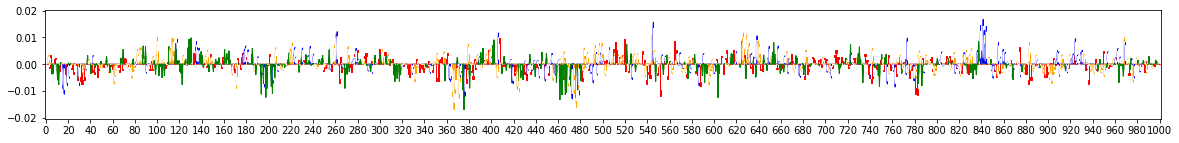

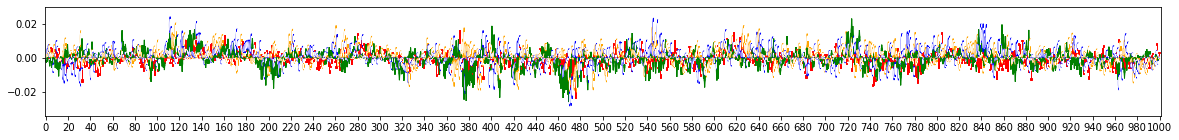

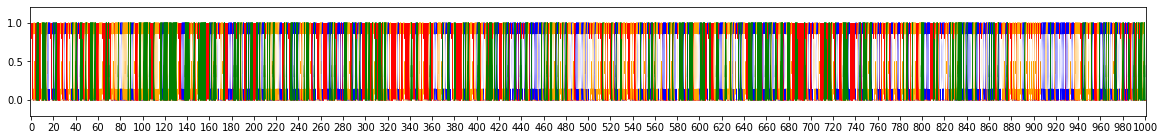

In [35]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(task_to_scores['Dex'][0], subticks_frequency=20)
viz_sequence.plot_weights(task_to_hyp_scores['Dex'][0], subticks_frequency=20)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=20)

MEMORY 0.3685376
On task Dex
Computing windowed sums on original
Generating null dist
peak(mu)= 0.0020402558074065135
Computing threshold
For increasing = True , the minimum IR precision was 0.36886699161173975 occurring at 8.907634764694639e-08 implying a frac_neg of 0.5844520674868906
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.16549702244617498 occurring at -7.841145270026662e-07 implying a frac_neg of 0.19831807302988383
To be conservative, adjusted frac neg is 0.95
Thresholds from null dist were -0.11193636123731265  and  0.09018196867356891 with frac passing 0.0002231237322515213
Passing windows frac was 0.0002231237322515213 , which is below  0.03 ; adjusting
Final raw thresholds are -0.052711256816927926  and  0.052711256816927926
Final transformed thresholds are -0.97  and  0.97


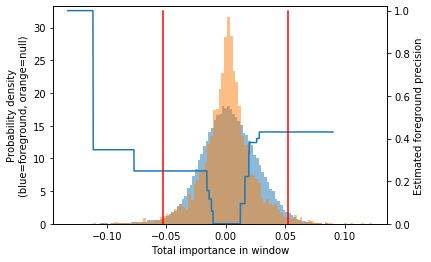

Got 437 coords
After resolving overlaps, got 437 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9699
MEMORY 0.354476032
437 identified in total
2 activity patterns with support >= 100 out of 2 possible patterns
Metacluster sizes:  [244, 193]
Idx to activities:  {0: '1', 1: '-1'}
MEMORY 0.354476032
On metacluster 1
Metacluster size 193
Relevant tasks:  ('Dex',)
Relevant signs:  (-1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 193
(Round 1) Computing coarse affmat
MEMORY 0.354476032
Beginning embedding computation
MEMORY 0.354476032
At the beginning of embedding call
MEMORY 0.354476032
before computing embeddings fwd
MEMORY 0.354476032


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   13.3s
[Parallel(n_jobs=10)]: Done 193 out of 193 | elapsed:   42.9s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


after computing embeddings fwd
MEMORY 0.358158336


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.8s
[Parallel(n_jobs=10)]: Done 193 out of 193 | elapsed:   35.5s finished


after computing embeddings rev
MEMORY 0.359940096
before computing sparse embeddings fwd
MEMORY 0.359940096
Constructing csr matrix...
csr matrix made in 0.10372400283813477 s
after computing sparse embeddings fwd
MEMORY 0.361848832
before computing sparse embeddings rev
MEMORY 0.361848832
Constructing csr matrix...
csr matrix made in 0.03727245330810547 s
after computing sparse embeddings rev
MEMORY 0.363024384
Finished embedding computation in 78.68 s
MEMORY 0.363024384
Starting affinity matrix computations
MEMORY 0.363024384
Batching in slices of size 193


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

Finished affinity matrix computations in 1.19 s
MEMORY 0.363552768
(Round 1) Computed coarse affmat
MEMORY 0.363552768
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 0.363552768
Launching nearest neighbors affmat calculation job
MEMORY 0.363552768


Parallel runs completed
MEMORY 0.374059008
Job completed in: 1.8 s
MEMORY 0.374059008
Launching nearest neighbors affmat calculation job
MEMORY 0.374059008
Parallel runs completed
MEMORY 0.37916672
Job completed in: 1.8 s
MEMORY 0.37916672
(Round 1) Computed affinity matrix on nearest neighbors in 3.69 s
MEMORY 0.37916672
Filtered down to 109 of 193
(Round 1) Retained 109 rows out of 193 after filtering
MEMORY 0.3817472
(Round 1) Computing density adapted affmat
MEMORY 0.3817472
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominators
(Round 1) Computing clustering
MEMORY 0.381751296
Beginning preprocessing + Leiden
Affmat shape: 109


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.1s


Quality: 0.04944832620130713
Quality: 0.04958083505340106
Quality: 0.04963117045179317
Quality: 0.04967517992907759
Got 5 clusters after round 1
Counts:
{0: 33, 1: 33, 3: 9, 4: 6, 2: 28}
MEMORY 0.381882368
(Round 1) Aggregating seqlets in each cluster
MEMORY 0.381882368
Aggregating for cluster 0 with 33 seqlets
MEMORY 0.381882368
Trimming eliminated 0 seqlets out of 33
Skipped 1 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 1 with 33 seqlets
MEMORY 0.381620224
Trimming eliminated 0 seqlets out of 33
Aggregating for cluster 2 with 28 seqlets
MEMORY 0.381620224
Trimming eliminated 0 seqlets out of 28
Aggregating for cluster 3 with 9 seqlets
MEMORY 0.381620224


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    4.3s finished


Skipped 1 seqlets that went over sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 8
Skipped 1 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 4 with 6 seqlets
MEMORY 0.381620224
Trimming eliminated 0 seqlets out of 6
(Round 2) num seqlets: 106
(Round 2) Computing coarse affmat
MEMORY 0.381620224
Beginning embedding computation
MEMORY 0.381620224
At the beginning of embedding call
MEMORY 0.381620224
before computing embeddings fwd
MEMORY 0.381620224


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.5s
[Parallel(n_jobs=10)]: Done 106 out of 106 | elapsed:   19.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


after computing embeddings fwd
MEMORY 0.381988864


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.5s


after computing embeddings rev
MEMORY 0.382226432
before computing sparse embeddings fwd
MEMORY 0.382226432
Constructing csr matrix...
csr matrix made in 0.020028352737426758 s
after computing sparse embeddings fwd
MEMORY 0.382226432
before computing sparse embeddings rev
MEMORY 0.382226432
Constructing csr matrix...
csr matrix made in 0.019758939743041992 s
after computing sparse embeddings rev
MEMORY 0.382226432
Finished embedding computation in 39.46 s
MEMORY 0.382226432
Starting affinity matrix computations
MEMORY 0.382226432
Batching in slices of size 106


[Parallel(n_jobs=10)]: Done 106 out of 106 | elapsed:   19.8s finished
100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

Finished affinity matrix computations in 1.12 s
MEMORY 0.382230528
(Round 2) Computed coarse affmat
MEMORY 0.382230528
(Round 2) Computing affinity matrix on nearest neighbors
MEMORY 0.382230528
Launching nearest neighbors affmat calculation job
MEMORY 0.382230528


Parallel runs completed
MEMORY 0.38643712
Job completed in: 0.79 s
MEMORY 0.38643712
Launching nearest neighbors affmat calculation job
MEMORY 0.38643712
Parallel runs completed
MEMORY 0.39114752
Job completed in: 0.77 s
MEMORY 0.39114752
(Round 2) Computed affinity matrix on nearest neighbors in 1.63 s
MEMORY 0.39114752
Not applying filtering for rounds above first round
MEMORY 0.39114752
(Round 2) Computing density adapted affmat
MEMORY 0.39114752
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominators
(Round 2) Computing clustering
MEMORY 0.39114752
Beginning preprocessing + Leiden
Affmat shape: 106


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.8s


Quality: 0.05352306257239331
Got 6 clusters after round 2
Counts:
{3: 13, 1: 32, 0: 34, 4: 3, 2: 23, 5: 1}
MEMORY 0.3912704
(Round 2) Aggregating seqlets in each cluster
MEMORY 0.3912704
Aggregating for cluster 0 with 34 seqlets
MEMORY 0.3912704
Trimming eliminated 0 seqlets out of 34
Aggregating for cluster 1 with 32 seqlets
MEMORY 0.3912704
Skipped 1 due to duplicates
Trimming eliminated 0 seqlets out of 31
Aggregating for cluster 2 with 23 seqlets
MEMORY 0.3912704


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    4.2s finished


Trimming eliminated 0 seqlets out of 23
Aggregating for cluster 3 with 13 seqlets
MEMORY 0.3912704
Skipped 1 due to duplicates
Trimming eliminated 0 seqlets out of 12
Aggregating for cluster 4 with 3 seqlets
MEMORY 0.3912704
Trimming eliminated 0 seqlets out of 3
Aggregating for cluster 5 with 1 seqlets
MEMORY 0.3912704
Trimming eliminated 0 seqlets out of 1
Got 6 clusters
Splitting into subclusters...
MEMORY 0.3912704
Inspecting pattern 0 for spurious merging
Inspecting pattern 1 for spurious merging
Inspecting pattern 2 for spurious merging
Inspecting pattern 3 for spurious merging
Inspecting pattern 4 for spurious merging
Inspecting pattern 5 for spurious merging
Merging on 6 clusters
MEMORY 0.3912704
On merging iteration 1
Numbers for each pattern pre-subsample: [34, 31, 23, 12, 3, 1]
Numbers after subsampling: [34, 31, 23, 12, 3, 1]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.368457555770874 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.27325105

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.7s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   33.1s
[Parallel(n_jobs=10)]: Done 244 out of 244 | elapsed:   44.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


after computing embeddings fwd
MEMORY 0.391401472


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.6s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   32.9s


after computing embeddings rev
MEMORY 0.39256064
before computing sparse embeddings fwd
MEMORY 0.39256064
Constructing csr matrix...
csr matrix made in 0.04921913146972656 s
after computing sparse embeddings fwd
MEMORY 0.393658368
before computing sparse embeddings rev
MEMORY 0.393658368
Constructing csr matrix...
csr matrix made in 0.04570794105529785 s
after computing sparse embeddings rev
MEMORY 0.396632064
Finished embedding computation in 89.05 s
MEMORY 0.396632064
Starting affinity matrix computations
MEMORY 0.396632064
Batching in slices of size 244


[Parallel(n_jobs=10)]: Done 244 out of 244 | elapsed:   44.3s finished
100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

Finished affinity matrix computations in 1.16 s
MEMORY 0.396681216
(Round 1) Computed coarse affmat
MEMORY 0.388984832
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 0.388984832
Launching nearest neighbors affmat calculation job
MEMORY 0.388984832


Parallel runs completed
MEMORY 0.394665984
Job completed in: 2.71 s
MEMORY 0.394665984
Launching nearest neighbors affmat calculation job
MEMORY 0.394665984
Parallel runs completed
MEMORY 0.392310784
Job completed in: 2.61 s
MEMORY 0.392310784
(Round 1) Computed affinity matrix on nearest neighbors in 5.42 s
MEMORY 0.392572928
Filtered down to 163 of 244
(Round 1) Retained 163 rows out of 244 after filtering
MEMORY 0.392572928
(Round 1) Computing density adapted affmat
MEMORY 0.392572928
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominators
(Round 1) Computing clustering
MEMORY 0.392572928
Beginning preprocessing + Leiden
Affmat shape: 163


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.2s


Quality: 0.03840548396281008
Quality: 0.03852448094854711
Got 5 clusters after round 1
Counts:
{1: 64, 0: 69, 2: 28, 3: 1, 4: 1}
MEMORY 0.392572928
(Round 1) Aggregating seqlets in each cluster
MEMORY 0.392572928
Aggregating for cluster 0 with 69 seqlets
MEMORY 0.392572928
Trimming eliminated 0 seqlets out of 69
Aggregating for cluster 1 with 64 seqlets
MEMORY 0.392572928


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    4.7s finished


Skipped 1 due to duplicates
Trimming eliminated 0 seqlets out of 63
Aggregating for cluster 2 with 28 seqlets
MEMORY 0.392572928
Trimming eliminated 0 seqlets out of 28
Aggregating for cluster 3 with 1 seqlets
MEMORY 0.392572928
Trimming eliminated 0 seqlets out of 1
Aggregating for cluster 4 with 1 seqlets
MEMORY 0.392572928
Trimming eliminated 0 seqlets out of 1
(Round 2) num seqlets: 162
(Round 2) Computing coarse affmat
MEMORY 0.392572928
Beginning embedding computation
MEMORY 0.392572928
At the beginning of embedding call
MEMORY 0.392572928
before computing embeddings fwd
MEMORY 0.392572928


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done 162 out of 162 | elapsed:   29.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


after computing embeddings fwd
MEMORY 0.392572928


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.7s


after computing embeddings rev
MEMORY 0.392572928
before computing sparse embeddings fwd
MEMORY 0.392572928
Constructing csr matrix...
csr matrix made in 0.03628993034362793 s
after computing sparse embeddings fwd
MEMORY 0.392572928
before computing sparse embeddings rev
MEMORY 0.392572928
Constructing csr matrix...
csr matrix made in 0.029825210571289062 s
after computing sparse embeddings rev
MEMORY 0.392572928
Finished embedding computation in 59.65 s
MEMORY 0.392572928
Starting affinity matrix computations
MEMORY 0.392572928
Batching in slices of size 162


[Parallel(n_jobs=10)]: Done 162 out of 162 | elapsed:   29.9s finished
100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

Finished affinity matrix computations in 1.15 s
MEMORY 0.392572928
(Round 2) Computed coarse affmat
MEMORY 0.392572928
(Round 2) Computing affinity matrix on nearest neighbors
MEMORY 0.392572928
Launching nearest neighbors affmat calculation job
MEMORY 0.392572928


Parallel runs completed
MEMORY 0.390565888
Job completed in: 1.42 s
MEMORY 0.390565888
Launching nearest neighbors affmat calculation job
MEMORY 0.390565888
Parallel runs completed
MEMORY 0.388919296
Job completed in: 1.41 s
MEMORY 0.388919296
(Round 2) Computed affinity matrix on nearest neighbors in 2.9 s
MEMORY 0.388919296
Not applying filtering for rounds above first round
MEMORY 0.388919296
(Round 2) Computing density adapted affmat
MEMORY 0.388919296
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominators
(Round 2) Computing clustering
MEMORY 0.38905856
Beginning preprocessing + Leiden
Affmat shape: 162


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.1s


Quality: 0.0422986413503303
Quality: 0.04262576080911882
Quality: 0.0426722659814163
Got 5 clusters after round 2
Counts:
{0: 68, 3: 3, 2: 22, 4: 3, 1: 66}
MEMORY 0.38905856
(Round 2) Aggregating seqlets in each cluster
MEMORY 0.38905856
Aggregating for cluster 0 with 68 seqlets
MEMORY 0.38905856
Skipped 1 due to duplicates
Trimming eliminated 0 seqlets out of 67
Aggregating for cluster 1 with 66 seqlets
MEMORY 0.38905856


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    4.6s finished


Skipped 1 due to duplicates
Trimming eliminated 0 seqlets out of 65
Aggregating for cluster 2 with 22 seqlets
MEMORY 0.38905856
Trimming eliminated 0 seqlets out of 22
Aggregating for cluster 3 with 3 seqlets
MEMORY 0.38905856
Trimming eliminated 0 seqlets out of 3
Aggregating for cluster 4 with 3 seqlets
MEMORY 0.38905856
Trimming eliminated 0 seqlets out of 3
Got 5 clusters
Splitting into subclusters...
MEMORY 0.38905856
Inspecting pattern 0 for spurious merging
[t-SNE] Computed conditional probabilities for sample 67 / 67
[t-SNE] Mean sigma: 0.734196
Beginning preprocessing + Leiden
Affmat shape: 67


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  48 out of  67 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  67 out of  67 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.0s


Quality: 0.09871158525953556
Quality: 0.10035062375774986
Quality: 0.10174104762885826
Quality: 0.10472275320148329
Got subclusters: Counter({0: 23, 1: 19, 2: 14, 3: 11})
On merging iteration 1


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    4.2s finished


Numbers for each pattern pre-subsample: [23, 19, 14, 11]
Numbers after subsampling: [23, 19, 14, 11]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.11020946502685547 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.08725094795227051 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.0778191089630127 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.05622506141662598 s
Cluster sizes
[23 19 14 11]
Cross-contamination matrix:
[[1.   0.75 0.74 0.83]
 [0.38 1.   0.69 0.69]
 [0.23 0.47 1.   0.51]
 [0.34 0.52 0.57 1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.34 0.39 0.37]
 [0.34 1.   0.66 0.7 ]
 [0.39 0.66 1.   0.59]
 [0.37 0.7  0.59 1.  ]]
Inspecting pattern 1 for spurious merging
[t-SNE] Computed conditional probabilities for sample 65 / 65
[t-SNE] Mean sigma: 0.768623
Beginning preprocessing + Leiden
Affmat shape: 65


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  46 out of  65 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  65 out of  65 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.8s


Quality: 0.08299860819529643
Quality: 0.08355225919481896
Quality: 0.08530912647952964
Got subclusters: Counter({0: 25, 1: 21, 2: 17, 3: 2})
On merging iteration 1


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    4.2s finished


Numbers for each pattern pre-subsample: [25, 21, 17, 2]
Numbers after subsampling: [25, 21, 17, 2]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.1379096508026123 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.10545635223388672 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.08620858192443848 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.024743318557739258 s
Cluster sizes
[25 21 17  2]
Cross-contamination matrix:
[[1.   0.69 0.54 1.  ]
 [0.54 1.   0.56 0.83]
 [0.6  0.79 1.   1.  ]
 [0.   0.   0.   1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.61 0.48 0.5 ]
 [0.61 1.   0.55 0.56]
 [0.48 0.55 1.   0.5 ]
 [0.5  0.56 0.5  1.  ]]
Inspecting pattern 2 for spurious merging
Inspecting pattern 3 for spurious merging
Inspecting pattern 4 for spurious merging
Merging on 11 clusters
MEMORY 0.389189632
On merging iteration 1
Numbers for each pattern pre-subsample: [23, 19, 14, 11, 25, 21, 17, 2, 22, 3, 3]
Numbers after subsampling: 

In [36]:
import h5py
import numpy as np
%matplotlib inline
import modisco

#Uncomment to refresh modules for when tweaking code during development:
from importlib import reload
reload(modisco.util)
reload(modisco.pattern_filterer)
reload(modisco.aggregator)
reload(modisco.core)
reload(modisco.seqlet_embedding.advanced_gapped_kmer)
reload(modisco.affinitymat.transformers)
reload(modisco.affinitymat.core)
reload(modisco.affinitymat)
reload(modisco.cluster.core)
reload(modisco.cluster)
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
reload(modisco.tfmodisco_workflow)
reload(modisco)

null_per_pos_scores = modisco.coordproducers.LaplaceNullDist(num_to_samp=5000)
tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    target_seqlet_fdr=0.15,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        #Note: as of version 0.5.6.0, it's possible to use the results of a motif discovery
                        # software like MEME to improve the TF-MoDISco clustering. To use the meme-based
                        # initialization, you would specify the initclusterer_factory as shown in the
                        # commented-out code below:
                        #initclusterer_factory=modisco.clusterinit.memeinit.MemeInitClustererFactory(    
                        #    meme_command="meme", base_outdir="meme_out",            
                        #    max_num_seqlets_to_use=10000, nmotifs=10, n_jobs=1),
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        final_flank_to_add=5,
                        final_min_cluster_size=60,
                        #use_pynnd=True can be used for faster nn comp at coarse grained step
                        # (it will use pynndescent), but note that pynndescent may crash
                        #use_pynnd=True, 
                        n_cores=10)
                )(
                 task_names=["Dex"],#, "task1", "task2"],
                 contrib_scores=task_to_scores,
                 hypothetical_contribs=task_to_hyp_scores,
                 one_hot=onehot_data,
                 null_per_pos_scores=null_per_pos_scores)

In [37]:
import h5py
import modisco.util
reload(modisco.util)


fdiry = "/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_results"
fname = "chr17_Model_DeepSTARR_Dex_modisco.h5"
fpath = os.path.join(fdiry, fname)
grp = h5py.File(fpath, "w")
tfmodisco_results.save_hdf5(grp)
grp.close()

## Print results directly from hdf5

In [38]:
from collections import Counter
import numpy as np

from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

fdiry = "/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_results"
fname = "chr17_Model_DeepSTARR_Dex_modisco.h5"
fpath = os.path.join(fdiry, fname)
hdf5_results = h5py.File(fpath,"r")

Metaclusters heatmap


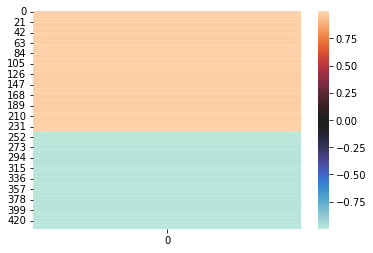

In [40]:
print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []
background = np.mean(onehot_data, axis=(0,1))

In [41]:
metacluster_names

['metacluster_0', 'metacluster_1']

Metaclusters heatmap


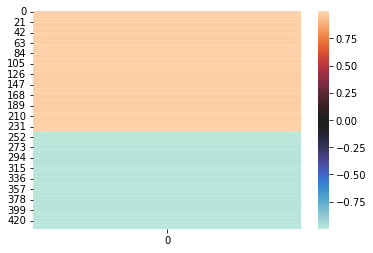

metacluster_0
activity pattern: [1]
No motifs found for this activity pattern
metacluster_1
activity pattern: [-1]
No motifs found for this activity pattern


In [42]:
print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []
background = np.mean(onehot_data, axis=(0,1))

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        #print("Task 1 hypothetical scores:")
        #viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        #print("Task 1 actual importance scores:")
        #viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        #print("Task 2 hypothetical scores:")
        #viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        #print("Task 2 actual importance scores:")
        #viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(pattern["sequence"]["fwd"])
        viz_sequence.plot_weights(pattern["sequence"]["rev"])
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        #Plot the subclustering too, if available
        if ("subclusters" in pattern):
            print("PLOTTING SUBCLUSTERS")
            subclusters = np.array(pattern["subclusters"])
            twod_embedding = np.array(pattern["twod_embedding"])
            plt.scatter(twod_embedding[:,0], twod_embedding[:,1], c=subclusters, cmap="tab20")
            plt.show()
            for subcluster_name in list(pattern["subcluster_to_subpattern"]["subcluster_names"]):
                subpattern = pattern["subcluster_to_subpattern"][subcluster_name]
                print(subcluster_name.decode("utf-8"), "size", len(subpattern["seqlets_and_alnmts"]["seqlets"]))
                subcluster = int(subcluster_name.decode("utf-8").split("_")[1])
                plt.scatter(twod_embedding[:,0], twod_embedding[:,1], c=(subclusters==subcluster))
                plt.show()
                viz_sequence.plot_weights(subpattern["task0_hypothetical_contribs"]["fwd"])
                viz_sequence.plot_weights(subpattern["task0_contrib_scores"]["fwd"])
                viz_sequence.plot_weights(subpattern["sequence"]["fwd"])
        
hdf5_results.close()